## Reinforcement Learning

In [1]:
import os
import math
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
import random
import scipy.stats as stats
import numpy as np
import pandas as pd
import pandas_ta as ta
import seaborn as sns
import matplotlib.pyplot as plt
from stable_baselines3 import PPO
import optuna
from pylab import plt, mpl
import yfinance as yf
import stable_baselines3
from stable_baselines3.common.callbacks import EvalCallback
import gym
import tensorflow as tf
plt.style.use('seaborn-v0_8')
mpl.rcParams['savefig.dpi'] = 300
mpl.rcParams['figure.figsize'] = (10, 10) 
mpl.rcParams['font.family'] = 'serif'
np.set_printoptions(precision=4, suppress=True)
os.environ['PYTHONHASHSEED'] = '0'
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

In [2]:
random.seed(100)
np.random.seed(100)
tf.random.set_seed(100)
np.random.seed(100)

In [3]:
# Retrieve historical Bitcoin data
symbol = 'BTC-USD'
yahoo_info = yf.Ticker(symbol)
df = yahoo_info.history(period="84mo")
df

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2016-12-15,780.070007,781.434998,777.802002,778.088013,81580096,0,0
2016-12-16,778.963013,785.031982,778.963013,784.906982,83608200,0,0
2016-12-17,785.166016,792.508972,784.864014,790.828979,78989800,0,0
2016-12-18,791.007996,794.737000,788.026001,790.530029,60524400,0,0
2016-12-19,790.692017,793.611023,790.320007,792.713989,74886400,0,0
...,...,...,...,...,...,...,...
2023-12-10,43728.382812,44034.625000,43593.285156,43779.699219,13000481418,0,0
2023-12-11,43792.019531,43808.375000,40234.578125,41243.832031,40632672038,0,0
2023-12-12,41238.734375,42048.304688,40667.562500,41450.222656,24779520132,0,0


In [4]:
# Apply technical analysis indicators to the DataFrame 
df = df.ta.ticker(symbol)

In [5]:
# Calculate returns
df['Returns'] = np.log(df['Close']).diff()
df['Ret_1M'] = df['Returns'].rolling(20).sum()

# Output first five values
df.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits,Returns,Ret_1M
Date,,,,,,,,,
2014-09-17,465.864014,468.174011,452.421997,457.334015,21056800,0,0,NaN,NaN
2014-09-18,456.859985,456.859985,413.104004,424.440002,34483200,0,0,-0.074643,NaN
2014-09-19,424.102997,427.834991,384.532013,394.795990,37919700,0,0,-0.072402,NaN
2014-09-20,394.673004,423.295990,389.882996,408.903992,36863600,0,0,0.035111,NaN
2014-09-21,408.084991,412.425995,393.181000,398.821014,26580100,0,0,-0.024968,NaN


In [6]:
# Define a custom trading strategy 
CustomStrategy = ta.Strategy(
    name="Momentum and Volatility",  
    description="SMA 50,200, BBANDS, RSI, MACD and Volume SMA 20",  

    # List of technical indicators to be applied to the DataFrame
    ta=[
        {"kind": "sma", "length": 50},  # Simple Moving Average with a period of 50
        {"kind": "sma", "length": 200},  # Simple Moving Average with a period of 200
        {"kind": "bbands", "length": 20},  # Bollinger Bands with a period of 20
        {"kind": "rsi"},  # Relative Strength Index (RSI)
        {"kind": "macd", "fast": 8, "slow": 21},  # Moving Average Convergence Divergence (MACD)
        {"kind": "sma", "close": "volume", "length": 20, "prefix": "VOLUME"},  # Volume-based Simple Moving Average with a period of 20
    ]
)

# Run the strategy on the DataFrame
df.ta.strategy(CustomStrategy)  
df

,Open,High,Low,Close,Volume,Dividends,Stock Splits,Returns,Ret_1M,SMA_50,...,BBL_20_2.0,BBM_20_2.0,BBU_20_2.0,BBB_20_2.0,BBP_20_2.0,RSI_14,MACD_8_21_9,MACDh_8_21_9,MACDs_8_21_9,VOLUME_SMA_20
Date,,,,,,,,,,,,,,,,,,,,,
2014-09-17,465.864014,468.174011,452.421997,457.334015,21056800,0,0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-09-18,456.859985,456.859985,413.104004,424.440002,34483200,0,0,-0.074643,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-09-19,424.102997,427.834991,384.532013,394.795990,37919700,0,0,-0.072402,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-09-20,394.673004,423.295990,389.882996,408.903992,36863600,0,0,0.035111,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-09-21,408.084991,412.425995,393.181000,398.821014,26580100,0,0,-0.024968,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-10,43728.382812,44034.625000,43593.285156,43779.699219,13000481418,0,0,0.001228,0.155444,37162.993711,...,34154.589540,39855.203711,45555.817882,28.606624,0.844217,74.093542,2334.154046,379.438552,1954.715495,2.162077e+10
2023-12-11,43792.019531,43808.375000,40234.578125,41243.832031,40632672038,0,0,-0.059669,0.141168,37387.992422,...,34711.795644,40126.704688,45541.613731,26.989054,0.603153,57.096854,1917.111761,-30.082987,1947.194748,2.239380e+10
2023-12-12,41238.734375,42048.304688,40667.562500,41450.222656,24779520132,0,0,0.004992,0.101958,37555.272187,...,35030.597252,40327.598828,45624.600405,26.269859,0.605968,57.942475,1610.605646,-269.271282,1879.876927,2.241291e+10


In [7]:
features_list = []
for r in range(10, 65, 5):
    df['Ret_'+str(r)] = df.Returns.rolling(r).sum()
    df['Std_'+str(r)] = df.Returns.rolling(r).std()
    features_list.append('Ret_'+str(r))
    features_list.append('Std_'+str(r))

# Drop columns from dataframe
df.drop(['Dividends','Stock Splits'], axis=1, inplace=True)    

# Drop NaN values
df.dropna(inplace=True)

Text(0.5, 1.0, 'Features Set Correlations')

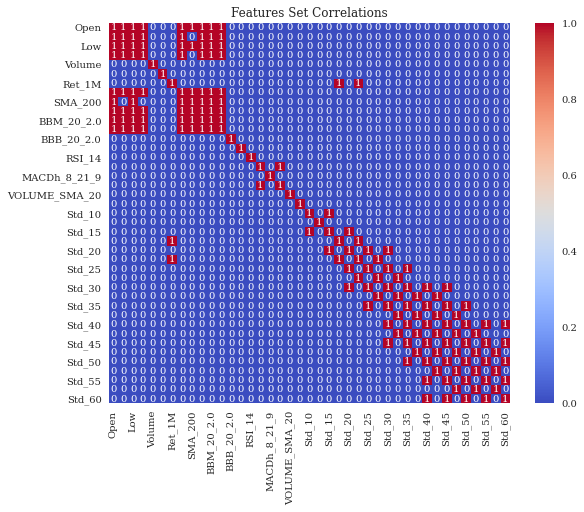

In [8]:
# Check correlated features
plt.figure(figsize=(9, 7))
sns.heatmap(df.corr()>0.9,
annot=True,
cmap="coolwarm",
cbar=True); 
plt.title('Features Set Correlations')

In [9]:
# Remove the first feature that is correlated with any other feature
def correlated_features(data, threshold=0.9):
    col_corr = set()
    corr_matrix = df.corr()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if abs(corr_matrix.iloc[i, j]) > threshold:
                colname = corr_matrix.columns[i]
                col_corr.add(colname)
    return col_corr

In [10]:
# Total correlated features
drop_correlated_features = correlated_features(df)

# Drop the highly correlated features
X = df.drop(drop_correlated_features, axis=1)

# Record feature names
feature_names = X.columns

X['d'] = (X['Returns'] > 0).astype(int)

X

,Open,Volume,Returns,Ret_1M,BBB_20_2.0,BBP_20_2.0,RSI_14,MACD_8_21_9,MACDh_8_21_9,VOLUME_SMA_20,Ret_10,Std_10,Ret_15,d
Date,,,,,,,,,,,,,,
2015-04-04,254.291000,12493500,-0.002461,-0.121224,19.783932,0.442125,47.508324,-4.456203,1.282742,2.583737e+07,0.030009,0.019732,-0.031245,0
2015-04-05,253.761002,19649200,0.026838,-0.108945,15.833630,0.635214,52.432292,-2.852673,2.309017,2.574402e+07,0.047407,0.021084,0.002201,1
2015-04-06,260.721008,20034200,-0.019788,-0.111068,11.549890,0.563389,48.785829,-2.331718,2.263978,2.567088e+07,0.033685,0.022278,-0.047647,0
2015-04-07,255.274002,18467400,-0.009090,-0.012244,11.517194,0.489754,47.185618,-2.219858,1.900670,2.374384e+07,0.001510,0.021421,-0.052174,0
2015-04-08,253.063995,30086400,-0.032753,-0.062897,11.571791,0.237969,41.956153,-3.167171,0.762686,2.261156e+07,0.009468,0.019822,-0.002336,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-10,43728.382812,13000481418,0.001228,0.155444,28.606624,0.844217,74.093542,2334.154046,379.438552,2.162077e+10,0.149172,0.022192,0.146946,1
2023-12-11,43792.019531,40632672038,-0.059669,0.141168,26.989054,0.603153,57.096854,1917.111761,-30.082987,2.239380e+10,0.063953,0.031896,0.095718,0
2023-12-12,41238.734375,24779520132,0.004992,0.101958,26.269859,0.605968,57.942475,1610.605646,-269.271282,2.241291e+10,0.048792,0.031528,0.106729,1


In [11]:
class Finance(gym.Env):
    def __init__(self, data, features, window, lags,
                 leverage=1, min_performance=0.85,
                 start=0, end=None, mu=None, std=None):
        super(Finance, self).__init__()
        self.features = features
        self.n_features = len(features)
        self.window = window
        self.lags = lags
        self.leverage = leverage
        self.min_performance = min_performance
        self.start = start
        self.end = end
        self.mu = mu
        self.std = std
        self.data = data
        self.episode_performances = []

        # Initialize performance and benchmark_performance attributes
        self.performance = 1
        self.benchmark_performance = 1

        # Define action and observation space
        self.observation_space = gym.spaces.Box(low=-np.inf, high=np.inf, shape=(self.lags, self.n_features), dtype=np.float32)
        self.action_space = gym.spaces.Discrete(2)

    def _get_state(self):
        return self.data[self.features].iloc[self.bar - self.lags:self.bar]

    def seed(self, seed):
        random.seed(seed)
        np.random.seed(seed)
 

    def reset(self):
        self.treward = 0
        self.accuracy = 0
        self.performance = 1
        self.bar = self.lags
        state = self.data[self.features].iloc[self.bar-self.lags:self.bar]
        return state.values

    def step(self, action):
        correct = action == self.data['d'].iloc[self.bar]
        ret = self.data['Returns'].iloc[self.bar] * self.leverage

        # Calculate rewards
        reward_1 = 1 if correct else -1
        reward_2 = abs(ret) if correct else -abs(ret)
        reward_3 = 0  

        # Compare agent's return to benchmark return
        benchmark_return = self.data['Returns'].iloc[self.bar]
        excess_return = ret - benchmark_return  # Excess return over benchmark

        # Reward for outperforming the benchmark
        outperformance_reward = excess_return if excess_return > 0 else 0

        # Update metrics
        self.treward += reward_1
        self.bar += 1
        self.accuracy = self.treward / (self.bar - self.lags)
        self.performance *= math.exp(reward_2)

        if self.performance < 0.85:  # drawdown
            reward_3 -= 2   # penalty

        # Dynamically adjust position based on rewards
        custom_metric = reward_1 + reward_2 + reward_3 + outperformance_reward 
        self.leverage = 1 + custom_metric / (self.bar - self.lags)

        # Define conditions for episode termination
        done = False
        if self.bar >= len(self.data):
            done = True

        # Get the next state
        state = self._get_state()

        # Combine rewards for a total reward signal
        total_reward = reward_1 + reward_2 + reward_3 + outperformance_reward 

        info = {
            'Performance': self.performance,
            'Accuracy': self.accuracy,
            'Excess_Return': excess_return,
            'Leverage': self.leverage
        }

        return state.values, total_reward, done, info


In [12]:
features = X.columns.tolist()

a = 0 
b = int(0.7 * len(X))
c = len(X) - b     

# Initialize learn_env
learn_env = Finance(data=X.iloc[a:a+b], features=features, window=10, lags=6,
                    leverage=1, min_performance=0.85,
                    start=0, end=None, mu=None, std=None)

# Initialize valid_env
valid_env = Finance(data=X.iloc[a+b:a+b+c], features=features, window=learn_env.window,
                    lags=learn_env.lags, leverage=learn_env.leverage,
                    min_performance=learn_env.min_performance,
                    start=0, end=None, mu=learn_env.mu, std=learn_env.std)


In [13]:
# Check the information 
learn_env.data[learn_env.features].info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2223 entries, 2015-04-04 to 2021-05-04
Data columns (total 14 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Open           2223 non-null   float64
 1   Volume         2223 non-null   int64  
 2   Returns        2223 non-null   float64
 3   Ret_1M         2223 non-null   float64
 4   BBB_20_2.0     2223 non-null   float64
 5   BBP_20_2.0     2223 non-null   float64
 6   RSI_14         2223 non-null   float64
 7   MACD_8_21_9    2223 non-null   float64
 8   MACDh_8_21_9   2223 non-null   float64
 9   VOLUME_SMA_20  2223 non-null   float64
 10  Ret_10         2223 non-null   float64
 11  Std_10         2223 non-null   float64
 12  Ret_15         2223 non-null   float64
 13  d              2223 non-null   int64  
dtypes: float64(12), int64(2)
memory usage: 260.5 KB


In [14]:
valid_env.data[valid_env.features].info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 954 entries, 2021-05-05 to 2023-12-15
Data columns (total 14 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Open           954 non-null    float64
 1   Volume         954 non-null    int64  
 2   Returns        954 non-null    float64
 3   Ret_1M         954 non-null    float64
 4   BBB_20_2.0     954 non-null    float64
 5   BBP_20_2.0     954 non-null    float64
 6   RSI_14         954 non-null    float64
 7   MACD_8_21_9    954 non-null    float64
 8   MACDh_8_21_9   954 non-null    float64
 9   VOLUME_SMA_20  954 non-null    float64
 10  Ret_10         954 non-null    float64
 11  Std_10         954 non-null    float64
 12  Ret_15         954 non-null    float64
 13  d              954 non-null    int64  
dtypes: float64(12), int64(2)
memory usage: 111.8 KB


In [15]:
#Train the model using PPO
model = PPO("MlpPolicy", learn_env, verbose=1)
model.learn(total_timesteps=100000)

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
-----------------------------
| time/              |      |
|    fps             | 346  |
|    iterations      | 1    |
|    time_elapsed    | 5    |
|    total_timesteps | 2048 |
-----------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 2.22e+03    |
|    ep_rew_mean          | -1.34e+03   |
| time/                   |             |
|    fps                  | 290         |
|    iterations           | 2           |
|    time_elapsed         | 14          |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.012813474 |
|    clip_fraction        | 0.0912      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.68       |
|    explained_variance   | -0.0027     |
|    learning_rate        | 0.0003      |
|    loss               

In [16]:
def backtest_strategy(env, model, num_runs=100):
    df = env.data.copy()
    df['Actions'] = 0
    df['Rewards'] = 0
    df['Strategy_Returns'] = 0

    for _ in range(num_runs):
        obs = env.reset()
        done = False
        actions = []
        rewards = []
        strategy_returns = []

        while not done:
            action, _states = model.predict(obs)
            actions.append(action)
            obs, reward, done, info = env.step(action)
            rewards.append(reward)

            # Retrieve leverage from the environment 
            current_leverage = info['Leverage']

            # Calculate market return for the step
            market_return = df['Returns'].iloc[env.bar - 1]

            # Leveraged positions
            if action == 1:  # Long 
                strategy_return = market_return * current_leverage
            else:  # Short 
                strategy_return = -market_return * current_leverage

            strategy_returns.append(strategy_return)

        temp_df = df.iloc[env.lags:env.bar].copy()
        temp_df['Actions'] = actions
        temp_df['Rewards'] = rewards
        temp_df['Strategy_Returns'] = strategy_returns    

        # Update the main DataFrame with results from each run
        df.iloc[env.lags:env.bar, df.columns.get_loc('Actions')] += temp_df['Actions']
        df.iloc[env.lags:env.bar, df.columns.get_loc('Rewards')] += temp_df['Rewards']
        df.iloc[env.lags:env.bar, df.columns.get_loc('Strategy_Returns')] += temp_df['Strategy_Returns']

    # Average the actions, rewards, and strategy returns over the runs
    df['Actions'] /= num_runs
    df['Rewards'] /= num_runs
    df['Strategy_Returns'] /= num_runs

    return df


In [17]:
def calculate_metrics(df):
    # Metrics for Strategy
    total_return = (df['Strategy_Returns'].sum() + 1) * 100 - 100  
    max_drawdown = ((df['Strategy_Returns'].cumsum().cummax() - df['Strategy_Returns'].cumsum()).max()) * 100 
    annualized_sharpe_ratio = df['Strategy_Returns'].mean() / df['Strategy_Returns'].std() * np.sqrt(252)
   
    # Metrics for Benchmark
    benchmark_total_return = (df['Returns'].sum() + 1) * 100 - 100  
    benchmark_max_drawdown = ((df['Returns'].cumsum().cummax() - df['Returns'].cumsum()).max()) * 100
    benchmark_annualized_sharpe_ratio = df['Returns'].mean() / df['Returns'].std() * np.sqrt(252)
    
    return (total_return, max_drawdown, annualized_sharpe_ratio), (benchmark_total_return, benchmark_max_drawdown, benchmark_annualized_sharpe_ratio)

In [18]:
# Backtest the strategy
results = backtest_strategy(valid_env, model)
    
# Calculate metrics for strategy and benchmark
strategy_metrics, benchmark_metrics = calculate_metrics(results)

In [19]:
# Create a DataFrame to display the metrics
metrics_df = pd.DataFrame(index=['Total Return (%)', 'Max Drawdown (%)', 'Annualized Sharpe Ratio'])
metrics_df['Strategy'] = strategy_metrics
metrics_df['Benchmark'] = benchmark_metrics

# Display the DataFrame
metrics_df.round(4)

,Strategy,Benchmark
Total Return (%),25.1945,-21.6774
Max Drawdown (%),130.2232,145.3912
Annualized Sharpe Ratio,0.1576,-0.1119


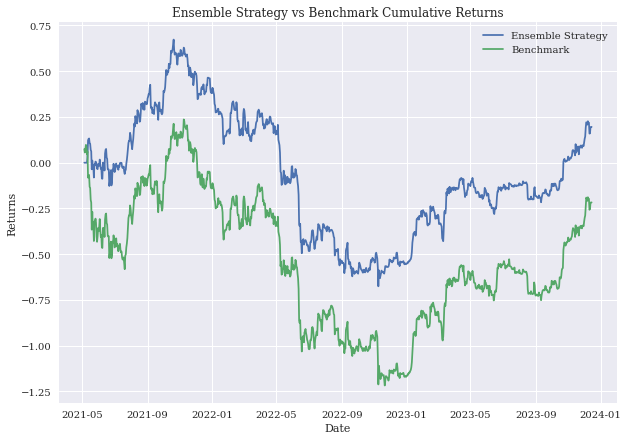

In [20]:
# Backtest the strategy
results = backtest_strategy(valid_env, model)

# Calculate cumulative returns
strategy_cumulative_returns = results['Strategy_Returns'].cumsum()
benchmark_cumulative_returns = results['Returns'].cumsum()

# Plot the results
plt.figure(figsize=(10, 7))
plt.plot(strategy_cumulative_returns, label='Ensemble Strategy')
plt.plot(benchmark_cumulative_returns, label='Benchmark')
plt.xlabel('Date')
plt.ylabel('Returns')
plt.title('Ensemble Strategy vs Benchmark Cumulative Returns')
plt.legend()
plt.grid(True)
plt.show()

In [31]:
def evaluate_model(model, env, num_episodes=10):
    all_episode_returns = []
    for _ in range(num_episodes):
        obs = env.reset()
        done = False
        cumulative_return = 1  # Starting with an initial value of 1 
        while not done:
            action, _states = model.predict(obs)
            obs, reward, done, _ = env.step(action)
            benchmark_return = env.data['Returns'].iloc[env.bar - 1]
            cumulative_return *= (1 + benchmark_return * env.leverage)

            if done:
                # Calculate the episode return
                episode_return = cumulative_return - 1
                all_episode_returns.append(episode_return)

    # Calculate Sharpe Ratio
    mean_return = np.mean(all_episode_returns)
    std_return = np.std(all_episode_returns)
    sharpe_ratio = mean_return / std_return if std_return != 0 else 0

    return sharpe_ratio


def optimize_ppo(trial):
    # Define the environment
    env = learn_env  

    # Hyperparameters to be tuned
    learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
    gamma = trial.suggest_uniform('gamma', 0.8, 0.9999)
    gae_lambda = trial.suggest_uniform('gae_lambda', 0.8, 0.95)
    entropy_coefficient = trial.suggest_loguniform('entropy_coefficient', 1e-5, 1e-1)
    clip_range = trial.suggest_uniform('clip_range', 0.1, 0.3)
    value_function_coefficient = trial.suggest_uniform('value_function_coefficient', 0.5, 1)

    # Create the model with suggested hyperparameters
    model = PPO("MlpPolicy", env, learning_rate=learning_rate, gamma=gamma, 
                gae_lambda=gae_lambda, ent_coef=entropy_coefficient, 
                clip_range=clip_range, vf_coef=value_function_coefficient, verbose=1)

    # Train the model
    model.learn(total_timesteps=10000)

    # Evaluate the model
    average_reward = evaluate_model(model, env)
    return average_reward

# Create the Optuna study
study = optuna.create_study(direction='maximize')
study.optimize(optimize_ppo, n_trials=25)

[I 2023-12-15 00:47:37,311] A new study created in memory with name: no-name-5308862d-c167-4417-b0c0-88f751302954
<ipython-input-31-2ea8e24ef580>:31: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
<ipython-input-31-2ea8e24ef580>:32: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  gamma = trial.suggest_uniform('gamma', 0.8, 0.9999)
<ipython-input-31-2ea8e24ef580>:33: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  ga

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
-----------------------------
| time/              |      |
|    fps             | 284  |
|    iterations      | 1    |
|    time_elapsed    | 7    |
|    total_timesteps | 2048 |
-----------------------------
---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 2.22e+03  |
|    ep_rew_mean          | -3.78e+03 |
| time/                   |           |
|    fps                  | 283       |
|    iterations           | 2         |
|    time_elapsed         | 14        |
|    total_timesteps      | 4096      |
| train/                  |           |
|    approx_kl            | 5.1996255 |
|    clip_fraction        | 0.969     |
|    clip_range           | 0.262     |
|    entropy_loss         | -0.0529   |
|    explained_variance   | -0.00756  |
|    learning_rate        | 0.0324    |
|    loss                 | 32        |
|    n_updates  

[I 2023-12-15 00:49:12,425] Trial 0 finished with value: 4402551476686227.0 and parameters: {'learning_rate': 0.03236575566173716, 'gamma': 0.9576658631118093, 'gae_lambda': 0.8921541849914536, 'entropy_coefficient': 0.0039088709516778555, 'clip_range': 0.26180071684018513, 'value_function_coefficient': 0.9286573063737757}. Best is trial 0 with value: 4402551476686227.0.
<ipython-input-31-2ea8e24ef580>:31: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
<ipython-input-31-2ea8e24ef580>:32: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  gamma = trial.suggest_uniform('gamma', 0.8, 0.9

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
-----------------------------
| time/              |      |
|    fps             | 326  |
|    iterations      | 1    |
|    time_elapsed    | 6    |
|    total_timesteps | 2048 |
-----------------------------
---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 2.22e+03  |
|    ep_rew_mean          | -3.02e+03 |
| time/                   |           |
|    fps                  | 270       |
|    iterations           | 2         |
|    time_elapsed         | 15        |
|    total_timesteps      | 4096      |
| train/                  |           |
|    approx_kl            | 13.772211 |
|    clip_fraction        | 0.997     |
|    clip_range           | 0.251     |
|    entropy_loss         | -0.00229  |
|    explained_variance   | 0.0102    |
|    learning_rate        | 0.0868    |
|    loss                 | 7.9       |
|    n_updates  

[I 2023-12-15 00:50:51,134] Trial 1 finished with value: 5177552.404713134 and parameters: {'learning_rate': 0.08675705025512392, 'gamma': 0.821575286457786, 'gae_lambda': 0.9274814106611512, 'entropy_coefficient': 0.0015257406936064154, 'clip_range': 0.25079755608532317, 'value_function_coefficient': 0.5553235136834045}. Best is trial 0 with value: 4402551476686227.0.
<ipython-input-31-2ea8e24ef580>:31: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
<ipython-input-31-2ea8e24ef580>:32: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  gamma = trial.suggest_uniform('gamma', 0.8, 0.999

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
-----------------------------
| time/              |      |
|    fps             | 371  |
|    iterations      | 1    |
|    time_elapsed    | 5    |
|    total_timesteps | 2048 |
-----------------------------
---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 2.22e+03  |
|    ep_rew_mean          | -834      |
| time/                   |           |
|    fps                  | 323       |
|    iterations           | 2         |
|    time_elapsed         | 12        |
|    total_timesteps      | 4096      |
| train/                  |           |
|    approx_kl            | 15.997837 |
|    clip_fraction        | 0.997     |
|    clip_range           | 0.287     |
|    entropy_loss         | -0.00272  |
|    explained_variance   | -0.0274   |
|    learning_rate        | 0.0854    |
|    loss                 | 17        |
|    n_updates  

[I 2023-12-15 00:52:23,392] Trial 2 finished with value: 5177552.404713134 and parameters: {'learning_rate': 0.08536709567588449, 'gamma': 0.8945021032796626, 'gae_lambda': 0.9032509050111435, 'entropy_coefficient': 0.08414570285099947, 'clip_range': 0.2866544845162644, 'value_function_coefficient': 0.7869666043152386}. Best is trial 0 with value: 4402551476686227.0.
<ipython-input-31-2ea8e24ef580>:31: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
<ipython-input-31-2ea8e24ef580>:32: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  gamma = trial.suggest_uniform('gamma', 0.8, 0.9999)

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
-----------------------------
| time/              |      |
|    fps             | 321  |
|    iterations      | 1    |
|    time_elapsed    | 6    |
|    total_timesteps | 2048 |
-----------------------------
------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 2.22e+03     |
|    ep_rew_mean          | -2.07e+03    |
| time/                   |              |
|    fps                  | 286          |
|    iterations           | 2            |
|    time_elapsed         | 14           |
|    total_timesteps      | 4096         |
| train/                  |              |
|    approx_kl            | 0.0030387102 |
|    clip_fraction        | 0.209        |
|    clip_range           | 0.114        |
|    entropy_loss         | -0.689       |
|    explained_variance   | -0.00223     |
|    learning_rate        | 0.00544      |
|    los

[I 2023-12-15 00:54:05,168] Trial 3 finished with value: 38.533949912790966 and parameters: {'learning_rate': 0.0054396073969190115, 'gamma': 0.9792501981776229, 'gae_lambda': 0.8345650470260157, 'entropy_coefficient': 0.04033721108730343, 'clip_range': 0.11383845083195646, 'value_function_coefficient': 0.5261624426618163}. Best is trial 0 with value: 4402551476686227.0.
<ipython-input-31-2ea8e24ef580>:31: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
<ipython-input-31-2ea8e24ef580>:32: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  gamma = trial.suggest_uniform('gamma', 0.8, 0.9

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
-----------------------------
| time/              |      |
|    fps             | 323  |
|    iterations      | 1    |
|    time_elapsed    | 6    |
|    total_timesteps | 2048 |
-----------------------------
----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 2.22e+03   |
|    ep_rew_mean          | -3.54e+03  |
| time/                   |            |
|    fps                  | 298        |
|    iterations           | 2          |
|    time_elapsed         | 13         |
|    total_timesteps      | 4096       |
| train/                  |            |
|    approx_kl            | 0.01118071 |
|    clip_fraction        | 0.214      |
|    clip_range           | 0.229      |
|    entropy_loss         | -0.677     |
|    explained_variance   | -0.0145    |
|    learning_rate        | 0.00607    |
|    loss                 | 17.2       |

[I 2023-12-15 00:55:45,497] Trial 4 finished with value: 33.62530030815537 and parameters: {'learning_rate': 0.006067431656325471, 'gamma': 0.912736306778274, 'gae_lambda': 0.8752802000646174, 'entropy_coefficient': 0.0001464430790052959, 'clip_range': 0.22866106018425197, 'value_function_coefficient': 0.9571989447289421}. Best is trial 0 with value: 4402551476686227.0.
<ipython-input-31-2ea8e24ef580>:31: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
<ipython-input-31-2ea8e24ef580>:32: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  gamma = trial.suggest_uniform('gamma', 0.8, 0.99

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
-----------------------------
| time/              |      |
|    fps             | 314  |
|    iterations      | 1    |
|    time_elapsed    | 6    |
|    total_timesteps | 2048 |
-----------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 2.22e+03    |
|    ep_rew_mean          | -1.63e+03   |
| time/                   |             |
|    fps                  | 272         |
|    iterations           | 2           |
|    time_elapsed         | 15          |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.004405942 |
|    clip_fraction        | 0           |
|    clip_range           | 0.298       |
|    entropy_loss         | -0.692      |
|    explained_variance   | -0.00344    |
|    learning_rate        | 3.93e-05    |
|    loss               

[I 2023-12-15 00:57:21,194] Trial 5 finished with value: 34.593826991773305 and parameters: {'learning_rate': 3.926763216095445e-05, 'gamma': 0.8768093319620928, 'gae_lambda': 0.9110434989396139, 'entropy_coefficient': 0.05567378330496441, 'clip_range': 0.29755792469902864, 'value_function_coefficient': 0.5251199523591716}. Best is trial 0 with value: 4402551476686227.0.
<ipython-input-31-2ea8e24ef580>:31: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
<ipython-input-31-2ea8e24ef580>:32: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  gamma = trial.suggest_uniform('gamma', 0.8, 0.9

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
-----------------------------
| time/              |      |
|    fps             | 350  |
|    iterations      | 1    |
|    time_elapsed    | 5    |
|    total_timesteps | 2048 |
-----------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 2.22e+03    |
|    ep_rew_mean          | -1.76e+03   |
| time/                   |             |
|    fps                  | 302         |
|    iterations           | 2           |
|    time_elapsed         | 13          |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.008636799 |
|    clip_fraction        | 0.0765      |
|    clip_range           | 0.142       |
|    entropy_loss         | -0.687      |
|    explained_variance   | 0.00323     |
|    learning_rate        | 7.96e-05    |
|    loss               

[I 2023-12-15 00:58:50,657] Trial 6 finished with value: 27.935362880000206 and parameters: {'learning_rate': 7.958898236141542e-05, 'gamma': 0.8430485695761012, 'gae_lambda': 0.8447617837709734, 'entropy_coefficient': 0.002470138227496458, 'clip_range': 0.1417269802227282, 'value_function_coefficient': 0.908527190032228}. Best is trial 0 with value: 4402551476686227.0.
<ipython-input-31-2ea8e24ef580>:31: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
<ipython-input-31-2ea8e24ef580>:32: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  gamma = trial.suggest_uniform('gamma', 0.8, 0.99

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
-----------------------------
| time/              |      |
|    fps             | 370  |
|    iterations      | 1    |
|    time_elapsed    | 5    |
|    total_timesteps | 2048 |
-----------------------------
-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 2.22e+03      |
|    ep_rew_mean          | -1.14e+03     |
| time/                   |               |
|    fps                  | 322           |
|    iterations           | 2             |
|    time_elapsed         | 12            |
|    total_timesteps      | 4096          |
| train/                  |               |
|    approx_kl            | 1.9211497e-05 |
|    clip_fraction        | 0             |
|    clip_range           | 0.183         |
|    entropy_loss         | -0.693        |
|    explained_variance   | -0.000359     |
|    learning_rate        | 1.33e-05

[I 2023-12-15 01:00:18,023] Trial 7 finished with value: 28.373952115824647 and parameters: {'learning_rate': 1.3332864185720682e-05, 'gamma': 0.9009271966492515, 'gae_lambda': 0.9129370136919445, 'entropy_coefficient': 0.00010380092441227916, 'clip_range': 0.18308160710483024, 'value_function_coefficient': 0.5912999258317047}. Best is trial 0 with value: 4402551476686227.0.
<ipython-input-31-2ea8e24ef580>:31: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
<ipython-input-31-2ea8e24ef580>:32: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  gamma = trial.suggest_uniform('gamma', 0.8,

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
-----------------------------
| time/              |      |
|    fps             | 376  |
|    iterations      | 1    |
|    time_elapsed    | 5    |
|    total_timesteps | 2048 |
-----------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 2.22e+03    |
|    ep_rew_mean          | -3.16e+03   |
| time/                   |             |
|    fps                  | 329         |
|    iterations           | 2           |
|    time_elapsed         | 12          |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.006831165 |
|    clip_fraction        | 0.00835     |
|    clip_range           | 0.27        |
|    entropy_loss         | -0.687      |
|    explained_variance   | 0.0197      |
|    learning_rate        | 0.000528    |
|    loss               

[I 2023-12-15 01:01:46,803] Trial 8 finished with value: 42.74535958029787 and parameters: {'learning_rate': 0.0005284224480982699, 'gamma': 0.8928984047821424, 'gae_lambda': 0.8276938996172497, 'entropy_coefficient': 1.0560587588533259e-05, 'clip_range': 0.27035665030343176, 'value_function_coefficient': 0.706383920458912}. Best is trial 0 with value: 4402551476686227.0.
<ipython-input-31-2ea8e24ef580>:31: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
<ipython-input-31-2ea8e24ef580>:32: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  gamma = trial.suggest_uniform('gamma', 0.8, 0.

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
-----------------------------
| time/              |      |
|    fps             | 363  |
|    iterations      | 1    |
|    time_elapsed    | 5    |
|    total_timesteps | 2048 |
-----------------------------
----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 2.22e+03   |
|    ep_rew_mean          | -1.06e+03  |
| time/                   |            |
|    fps                  | 317        |
|    iterations           | 2          |
|    time_elapsed         | 12         |
|    total_timesteps      | 4096       |
| train/                  |            |
|    approx_kl            | 0.01581464 |
|    clip_fraction        | 0.18       |
|    clip_range           | 0.254      |
|    entropy_loss         | -0.676     |
|    explained_variance   | -0.0124    |
|    learning_rate        | 0.00573    |
|    loss                 | 18.7       |

[I 2023-12-15 01:03:13,703] Trial 9 finished with value: 49.78879330856259 and parameters: {'learning_rate': 0.0057314149436722694, 'gamma': 0.996154033964985, 'gae_lambda': 0.8311445955644708, 'entropy_coefficient': 0.006516219599715286, 'clip_range': 0.25398499881664494, 'value_function_coefficient': 0.8180822157975298}. Best is trial 0 with value: 4402551476686227.0.
<ipython-input-31-2ea8e24ef580>:31: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
<ipython-input-31-2ea8e24ef580>:32: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  gamma = trial.suggest_uniform('gamma', 0.8, 0.99

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
-----------------------------
| time/              |      |
|    fps             | 344  |
|    iterations      | 1    |
|    time_elapsed    | 5    |
|    total_timesteps | 2048 |
-----------------------------
------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 2.22e+03     |
|    ep_rew_mean          | -3.24e+03    |
| time/                   |              |
|    fps                  | 304          |
|    iterations           | 2            |
|    time_elapsed         | 13           |
|    total_timesteps      | 4096         |
| train/                  |              |
|    approx_kl            | 0.0077574747 |
|    clip_fraction        | 0.0869       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.686       |
|    explained_variance   | -0.000494    |
|    learning_rate        | 0.000799     |
|    los

[I 2023-12-15 01:04:43,916] Trial 10 finished with value: 25.130168563827276 and parameters: {'learning_rate': 0.0007991333017700759, 'gamma': 0.9487991561242748, 'gae_lambda': 0.9450195306247698, 'entropy_coefficient': 0.010781119282093857, 'clip_range': 0.19981899804520623, 'value_function_coefficient': 0.9924863446416768}. Best is trial 0 with value: 4402551476686227.0.
<ipython-input-31-2ea8e24ef580>:31: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
<ipython-input-31-2ea8e24ef580>:32: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  gamma = trial.suggest_uniform('gamma', 0.8, 0

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
-----------------------------
| time/              |      |
|    fps             | 347  |
|    iterations      | 1    |
|    time_elapsed    | 5    |
|    total_timesteps | 2048 |
-----------------------------
---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 2.22e+03  |
|    ep_rew_mean          | -1.4e+03  |
| time/                   |           |
|    fps                  | 313       |
|    iterations           | 2         |
|    time_elapsed         | 13        |
|    total_timesteps      | 4096      |
| train/                  |           |
|    approx_kl            | 18.894823 |
|    clip_fraction        | 0.997     |
|    clip_range           | 0.244     |
|    entropy_loss         | -0.00244  |
|    explained_variance   | 0.00206   |
|    learning_rate        | 0.0958    |
|    loss                 | 13.1      |
|    n_updates  

[I 2023-12-15 01:06:16,345] Trial 11 finished with value: 4402551476686227.0 and parameters: {'learning_rate': 0.09584013799986456, 'gamma': 0.8134122288773308, 'gae_lambda': 0.9432635418346513, 'entropy_coefficient': 0.0005672459434054709, 'clip_range': 0.24390128336810335, 'value_function_coefficient': 0.6654030373885079}. Best is trial 0 with value: 4402551476686227.0.
<ipython-input-31-2ea8e24ef580>:31: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
<ipython-input-31-2ea8e24ef580>:32: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  gamma = trial.suggest_uniform('gamma', 0.8, 0.

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
-----------------------------
| time/              |      |
|    fps             | 347  |
|    iterations      | 1    |
|    time_elapsed    | 5    |
|    total_timesteps | 2048 |
-----------------------------
----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 2.22e+03   |
|    ep_rew_mean          | -904       |
| time/                   |            |
|    fps                  | 315        |
|    iterations           | 2          |
|    time_elapsed         | 12         |
|    total_timesteps      | 4096       |
| train/                  |            |
|    approx_kl            | 0.56082267 |
|    clip_fraction        | 0.676      |
|    clip_range           | 0.228      |
|    entropy_loss         | -0.546     |
|    explained_variance   | -0.00715   |
|    learning_rate        | 0.0264     |
|    loss                 | 6.4        |

[I 2023-12-15 01:07:45,324] Trial 12 finished with value: 27118.00654065164 and parameters: {'learning_rate': 0.026420927889609366, 'gamma': 0.8003826478737401, 'gae_lambda': 0.8712279915957177, 'entropy_coefficient': 0.00024481887962372515, 'clip_range': 0.2284076712139392, 'value_function_coefficient': 0.6700761680962837}. Best is trial 0 with value: 4402551476686227.0.
<ipython-input-31-2ea8e24ef580>:31: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
<ipython-input-31-2ea8e24ef580>:32: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  gamma = trial.suggest_uniform('gamma', 0.8, 0.

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
-----------------------------
| time/              |      |
|    fps             | 427  |
|    iterations      | 1    |
|    time_elapsed    | 4    |
|    total_timesteps | 2048 |
-----------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 2.22e+03    |
|    ep_rew_mean          | -3.88e+03   |
| time/                   |             |
|    fps                  | 323         |
|    iterations           | 2           |
|    time_elapsed         | 12          |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.055646986 |
|    clip_fraction        | 0.614       |
|    clip_range           | 0.229       |
|    entropy_loss         | -0.594      |
|    explained_variance   | 0.0164      |
|    learning_rate        | 0.0216      |
|    loss               

[I 2023-12-15 01:38:13,717] Trial 13 finished with value: 5177552.404713134 and parameters: {'learning_rate': 0.02156105397905363, 'gamma': 0.936738930787228, 'gae_lambda': 0.8007261740604115, 'entropy_coefficient': 0.0006178791533901319, 'clip_range': 0.22870632261713084, 'value_function_coefficient': 0.8633015223205551}. Best is trial 0 with value: 4402551476686227.0.
<ipython-input-31-2ea8e24ef580>:31: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
<ipython-input-31-2ea8e24ef580>:32: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  gamma = trial.suggest_uniform('gamma', 0.8, 0.99

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
-----------------------------
| time/              |      |
|    fps             | 452  |
|    iterations      | 1    |
|    time_elapsed    | 4    |
|    total_timesteps | 2048 |
-----------------------------
----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 2.22e+03   |
|    ep_rew_mean          | -49.7      |
| time/                   |            |
|    fps                  | 375        |
|    iterations           | 2          |
|    time_elapsed         | 10         |
|    total_timesteps      | 4096       |
| train/                  |            |
|    approx_kl            | 0.27565175 |
|    clip_fraction        | 0.557      |
|    clip_range           | 0.169      |
|    entropy_loss         | -0.63      |
|    explained_variance   | -0.0235    |
|    learning_rate        | 0.0218     |
|    loss                 | 4.09       |

[I 2023-12-15 01:41:21,167] Trial 14 finished with value: 10707.204285531789 and parameters: {'learning_rate': 0.02178790971280634, 'gamma': 0.8484982010628895, 'gae_lambda': 0.9496999639987982, 'entropy_coefficient': 3.25230224864701e-05, 'clip_range': 0.16930743293208123, 'value_function_coefficient': 0.6491927381773858}. Best is trial 0 with value: 4402551476686227.0.
<ipython-input-31-2ea8e24ef580>:31: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
<ipython-input-31-2ea8e24ef580>:32: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  gamma = trial.suggest_uniform('gamma', 0.8, 0.9

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
-----------------------------
| time/              |      |
|    fps             | 342  |
|    iterations      | 1    |
|    time_elapsed    | 5    |
|    total_timesteps | 2048 |
-----------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 2.22e+03    |
|    ep_rew_mean          | -3.1e+03    |
| time/                   |             |
|    fps                  | 300         |
|    iterations           | 2           |
|    time_elapsed         | 13          |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.013886822 |
|    clip_fraction        | 0.081       |
|    clip_range           | 0.256       |
|    entropy_loss         | -0.682      |
|    explained_variance   | 0.00673     |
|    learning_rate        | 0.00219     |
|    loss               

[I 2023-12-15 01:42:48,618] Trial 15 finished with value: 25.721404455622746 and parameters: {'learning_rate': 0.00219059750246545, 'gamma': 0.9578492161095711, 'gae_lambda': 0.883737182137645, 'entropy_coefficient': 0.006157095337710059, 'clip_range': 0.2563065923319616, 'value_function_coefficient': 0.7387925513130653}. Best is trial 0 with value: 4402551476686227.0.
<ipython-input-31-2ea8e24ef580>:31: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
<ipython-input-31-2ea8e24ef580>:32: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  gamma = trial.suggest_uniform('gamma', 0.8, 0.999

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
-----------------------------
| time/              |      |
|    fps             | 365  |
|    iterations      | 1    |
|    time_elapsed    | 5    |
|    total_timesteps | 2048 |
-----------------------------
--------------------------------------
| rollout/                |          |
|    ep_len_mean          | 2.22e+03 |
|    ep_rew_mean          | -469     |
| time/                   |          |
|    fps                  | 321      |
|    iterations           | 2        |
|    time_elapsed         | 12       |
|    total_timesteps      | 4096     |
| train/                  |          |
|    approx_kl            | 9.266557 |
|    clip_fraction        | 0.994    |
|    clip_range           | 0.215    |
|    entropy_loss         | -0.00521 |
|    explained_variance   | -0.0101  |
|    learning_rate        | 0.0391   |
|    loss                 | 10.3     |
|    n_updates            | 10   

[I 2023-12-15 01:44:15,038] Trial 16 finished with value: 5177552.404713134 and parameters: {'learning_rate': 0.03913584390657926, 'gamma': 0.9231171641798604, 'gae_lambda': 0.8900719000412676, 'entropy_coefficient': 0.0006949341089711761, 'clip_range': 0.21466859469552121, 'value_function_coefficient': 0.6104799571992782}. Best is trial 0 with value: 4402551476686227.0.
<ipython-input-31-2ea8e24ef580>:31: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
<ipython-input-31-2ea8e24ef580>:32: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  gamma = trial.suggest_uniform('gamma', 0.8, 0.9

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
-----------------------------
| time/              |      |
|    fps             | 369  |
|    iterations      | 1    |
|    time_elapsed    | 5    |
|    total_timesteps | 2048 |
-----------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 2.22e+03    |
|    ep_rew_mean          | -850        |
| time/                   |             |
|    fps                  | 324         |
|    iterations           | 2           |
|    time_elapsed         | 12          |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.027989268 |
|    clip_fraction        | 0.0498      |
|    clip_range           | 0.275       |
|    entropy_loss         | -0.67       |
|    explained_variance   | -0.00379    |
|    learning_rate        | 0.000228    |
|    loss               

[I 2023-12-15 01:45:40,472] Trial 17 finished with value: 29.078107859566682 and parameters: {'learning_rate': 0.00022754393958386034, 'gamma': 0.8693031244901596, 'gae_lambda': 0.9309594311986842, 'entropy_coefficient': 0.015480591149731649, 'clip_range': 0.274637981942975, 'value_function_coefficient': 0.8531748895750513}. Best is trial 0 with value: 4402551476686227.0.
<ipython-input-31-2ea8e24ef580>:31: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
<ipython-input-31-2ea8e24ef580>:32: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  gamma = trial.suggest_uniform('gamma', 0.8, 0.

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
-----------------------------
| time/              |      |
|    fps             | 353  |
|    iterations      | 1    |
|    time_elapsed    | 5    |
|    total_timesteps | 2048 |
-----------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 2.22e+03    |
|    ep_rew_mean          | -3.43e+03   |
| time/                   |             |
|    fps                  | 309         |
|    iterations           | 2           |
|    time_elapsed         | 13          |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.011886431 |
|    clip_fraction        | 0.126       |
|    clip_range           | 0.246       |
|    entropy_loss         | -0.679      |
|    explained_variance   | 0.0053      |
|    learning_rate        | 0.00345     |
|    loss               

[I 2023-12-15 01:47:06,393] Trial 18 finished with value: 27.946695487581774 and parameters: {'learning_rate': 0.0034525747257034265, 'gamma': 0.9799081383784459, 'gae_lambda': 0.8587922276112241, 'entropy_coefficient': 0.002873111630005382, 'clip_range': 0.2461238615946836, 'value_function_coefficient': 0.7665338524295506}. Best is trial 0 with value: 4402551476686227.0.
<ipython-input-31-2ea8e24ef580>:31: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
<ipython-input-31-2ea8e24ef580>:32: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  gamma = trial.suggest_uniform('gamma', 0.8, 0.

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
-----------------------------
| time/              |      |
|    fps             | 392  |
|    iterations      | 1    |
|    time_elapsed    | 5    |
|    total_timesteps | 2048 |
-----------------------------
----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 2.22e+03   |
|    ep_rew_mean          | -2.51e+03  |
| time/                   |            |
|    fps                  | 323        |
|    iterations           | 2          |
|    time_elapsed         | 12         |
|    total_timesteps      | 4096       |
| train/                  |            |
|    approx_kl            | 0.00804045 |
|    clip_fraction        | 0.254      |
|    clip_range           | 0.201      |
|    entropy_loss         | -0.678     |
|    explained_variance   | -0.0145    |
|    learning_rate        | 0.0109     |
|    loss                 | 13.6       |

[I 2023-12-15 01:48:31,615] Trial 19 finished with value: 567.2818625078075 and parameters: {'learning_rate': 0.010907570159456117, 'gamma': 0.8071913387032221, 'gae_lambda': 0.9278447708976155, 'entropy_coefficient': 0.00023475682718899322, 'clip_range': 0.2006373009131193, 'value_function_coefficient': 0.9163164254991573}. Best is trial 0 with value: 4402551476686227.0.
<ipython-input-31-2ea8e24ef580>:31: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
<ipython-input-31-2ea8e24ef580>:32: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  gamma = trial.suggest_uniform('gamma', 0.8, 0.

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
-----------------------------
| time/              |      |
|    fps             | 370  |
|    iterations      | 1    |
|    time_elapsed    | 5    |
|    total_timesteps | 2048 |
-----------------------------
---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 2.22e+03  |
|    ep_rew_mean          | -201      |
| time/                   |           |
|    fps                  | 319       |
|    iterations           | 2         |
|    time_elapsed         | 12        |
|    total_timesteps      | 4096      |
| train/                  |           |
|    approx_kl            | 10.823604 |
|    clip_fraction        | 0.997     |
|    clip_range           | 0.273     |
|    entropy_loss         | -0.00221  |
|    explained_variance   | -0.0255   |
|    learning_rate        | 0.0984    |
|    loss                 | 4.01      |
|    n_updates  

[I 2023-12-15 01:49:57,703] Trial 20 finished with value: 4402551476686227.0 and parameters: {'learning_rate': 0.09839381262710863, 'gamma': 0.8471982939245846, 'gae_lambda': 0.897729093950876, 'entropy_coefficient': 0.0010080904536812591, 'clip_range': 0.27319884806825145, 'value_function_coefficient': 0.713983701342696}. Best is trial 0 with value: 4402551476686227.0.
<ipython-input-31-2ea8e24ef580>:31: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
<ipython-input-31-2ea8e24ef580>:32: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  gamma = trial.suggest_uniform('gamma', 0.8, 0.99

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
-----------------------------
| time/              |      |
|    fps             | 366  |
|    iterations      | 1    |
|    time_elapsed    | 5    |
|    total_timesteps | 2048 |
-----------------------------
---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 2.22e+03  |
|    ep_rew_mean          | -2.33e+03 |
| time/                   |           |
|    fps                  | 322       |
|    iterations           | 2         |
|    time_elapsed         | 12        |
|    total_timesteps      | 4096      |
| train/                  |           |
|    approx_kl            | 7.5201235 |
|    clip_fraction        | 0.997     |
|    clip_range           | 0.274     |
|    entropy_loss         | -0.00309  |
|    explained_variance   | -0.00837  |
|    learning_rate        | 0.0805    |
|    loss                 | 12.2      |
|    n_updates  

[I 2023-12-15 01:51:23,413] Trial 21 finished with value: 5177552.404713134 and parameters: {'learning_rate': 0.08045785167990334, 'gamma': 0.8317561837372652, 'gae_lambda': 0.8964613985907817, 'entropy_coefficient': 0.0007060347431438874, 'clip_range': 0.27421729637275843, 'value_function_coefficient': 0.7036900288022938}. Best is trial 0 with value: 4402551476686227.0.
<ipython-input-31-2ea8e24ef580>:31: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
<ipython-input-31-2ea8e24ef580>:32: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  gamma = trial.suggest_uniform('gamma', 0.8, 0.9

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
-----------------------------
| time/              |      |
|    fps             | 432  |
|    iterations      | 1    |
|    time_elapsed    | 4    |
|    total_timesteps | 2048 |
-----------------------------
---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 2.22e+03  |
|    ep_rew_mean          | -3.58e+03 |
| time/                   |           |
|    fps                  | 318       |
|    iterations           | 2         |
|    time_elapsed         | 12        |
|    total_timesteps      | 4096      |
| train/                  |           |
|    approx_kl            | 8.079245  |
|    clip_fraction        | 0.994     |
|    clip_range           | 0.293     |
|    entropy_loss         | -0.0112   |
|    explained_variance   | -0.0127   |
|    learning_rate        | 0.0441    |
|    loss                 | 9.38      |
|    n_updates  

[I 2023-12-15 01:55:13,271] Trial 22 finished with value: 5177552.404713134 and parameters: {'learning_rate': 0.044071980965227915, 'gamma': 0.8617659812691628, 'gae_lambda': 0.9196067047210635, 'entropy_coefficient': 0.0017193742509917255, 'clip_range': 0.29310817396541494, 'value_function_coefficient': 0.6390507773918545}. Best is trial 0 with value: 4402551476686227.0.
<ipython-input-31-2ea8e24ef580>:31: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
<ipython-input-31-2ea8e24ef580>:32: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  gamma = trial.suggest_uniform('gamma', 0.8, 0.

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
-----------------------------
| time/              |      |
|    fps             | 346  |
|    iterations      | 1    |
|    time_elapsed    | 5    |
|    total_timesteps | 2048 |
-----------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 2.22e+03    |
|    ep_rew_mean          | -2.57e+03   |
| time/                   |             |
|    fps                  | 312         |
|    iterations           | 2           |
|    time_elapsed         | 13          |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.036680304 |
|    clip_fraction        | 0.372       |
|    clip_range           | 0.267       |
|    entropy_loss         | -0.652      |
|    explained_variance   | 0.017       |
|    learning_rate        | 0.0119      |
|    loss               

[I 2023-12-15 01:56:50,035] Trial 23 finished with value: 50.5047246209662 and parameters: {'learning_rate': 0.011895783499326401, 'gamma': 0.8201219379106454, 'gae_lambda': 0.8662970181777712, 'entropy_coefficient': 0.000378692778245982, 'clip_range': 0.2671073714929926, 'value_function_coefficient': 0.7009897490023987}. Best is trial 0 with value: 4402551476686227.0.
<ipython-input-31-2ea8e24ef580>:31: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
<ipython-input-31-2ea8e24ef580>:32: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  gamma = trial.suggest_uniform('gamma', 0.8, 0.999

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
-----------------------------
| time/              |      |
|    fps             | 338  |
|    iterations      | 1    |
|    time_elapsed    | 6    |
|    total_timesteps | 2048 |
-----------------------------
---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 2.22e+03  |
|    ep_rew_mean          | -3.99e+03 |
| time/                   |           |
|    fps                  | 296       |
|    iterations           | 2         |
|    time_elapsed         | 13        |
|    total_timesteps      | 4096      |
| train/                  |           |
|    approx_kl            | 12.453245 |
|    clip_fraction        | 0.997     |
|    clip_range           | 0.238     |
|    entropy_loss         | -0.00318  |
|    explained_variance   | -0.0145   |
|    learning_rate        | 0.0928    |
|    loss                 | 8.41      |
|    n_updates  

[I 2023-12-15 01:58:30,620] Trial 24 finished with value: 4402551476686227.0 and parameters: {'learning_rate': 0.0928093002517942, 'gamma': 0.8500589896665534, 'gae_lambda': 0.9018020332586488, 'entropy_coefficient': 6.038449935007647e-05, 'clip_range': 0.23751847741941617, 'value_function_coefficient': 0.8101032516354052}. Best is trial 0 with value: 4402551476686227.0.


In [32]:
# Access the best parameters
best_params = study.best_params

# Create the optimized model with the best parameters
optimized_model = PPO("MlpPolicy", learn_env, 
                      learning_rate=best_params['learning_rate'],
                      gamma=best_params['gamma'],
                      gae_lambda=best_params['gae_lambda'],
                      ent_coef=best_params['entropy_coefficient'],
                      clip_range=best_params['clip_range'],
                      vf_coef=best_params['value_function_coefficient'],
                      verbose=0)

# Train the optimized model
optimized_model.learn(total_timesteps=10000)


In [44]:
best_params

{'learning_rate': 0.03236575566173716,
 'gamma': 0.9576658631118093,
 'gae_lambda': 0.8921541849914536,
 'entropy_coefficient': 0.0039088709516778555,
 'clip_range': 0.26180071684018513,
 'value_function_coefficient': 0.9286573063737757}

In [55]:
# Convert the best_params dictionary into a DataFrame
parameters = pd.DataFrame.from_dict(best_params, orient='index', columns=['Value'])

parameters.round(4)


,Value
learning_rate,0.0324
gamma,0.9577
gae_lambda,0.8922
entropy_coefficient,0.0039
clip_range,0.2618
value_function_coefficient,0.9287


In [34]:
# Backtest the strategy
best_results = backtest_strategy(valid_env, optimized_model)
    
# Calculate metrics for strategy and benchmark
best_strategy_metrics, benchmark_metrics = calculate_metrics(best_results)

In [35]:
# Create a DataFrame to display the metrics
best_metrics_df = pd.DataFrame(index=['Total Return (%)', 'Max Drawdown (%)', 'Annualized Sharpe Ratio'])
best_metrics_df['Strategy'] =best_strategy_metrics
best_metrics_df['Benchmark'] = benchmark_metrics

# Display the DataFrame
best_metrics_df.round(4)

,Strategy,Benchmark
Total Return (%),56.8488,-21.6774
Max Drawdown (%),102.0748,145.3912
Annualized Sharpe Ratio,0.2891,-0.1119


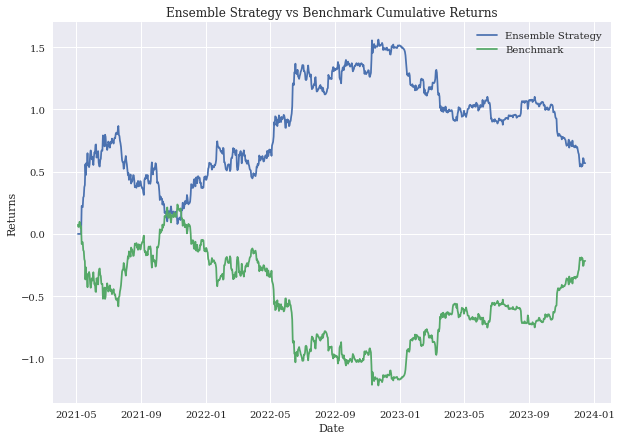

In [40]:
# Calculate cumulative returns
strategy_cumulative_returns = best_results['Strategy_Returns'].cumsum()
benchmark_cumulative_returns = results['Returns'].cumsum()

# Plot the results
plt.figure(figsize=(10, 7))
plt.plot(strategy_cumulative_returns, label='Ensemble Strategy')
plt.plot(benchmark_cumulative_returns, label='Benchmark')
plt.xlabel('Date')
plt.ylabel('Returns')
plt.title('Ensemble Strategy vs Benchmark Cumulative Returns')
plt.legend()
plt.grid(True)
plt.show()